# **Deep Learning With Python  -  CHAPTER 9**

- This code provides a **modular and structured framework** for training a deep learning model to perform **image segmentation** on the **Oxford Pets dataset** using **TensorFlow/Keras**.

- The `DatasetDownloader` class automates downloading and extracting the dataset. The `DataLoader` class handles **image preprocessing**, including resizing and converting images into numerical arrays.

- The `SegmentationModel` class constructs a **U-Net-inspired** convolutional neural network for segmentation. The `Trainer` class manages model training with **checkpointing**, while the `Evaluator` class visualizes the model's predictions.

- Finally, the `Plotter` class generates **training loss and validation loss curves**. This structured approach ensures **readability, modularity, and easy experimentation**, making it simple to extend the code for different segmentation tasks.

In [45]:
import numpy as np
import tensorflow as tf
import os, shutil, pathlib
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [46]:
class DataLoader:
    @staticmethod
    def load_mnist():
        (train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
        train_images = train_images.reshape((60000, 28, 28, 1)).astype("float32") / 255
        test_images = test_images.reshape((10000, 28, 28, 1)).astype("float32") / 255
        return train_images, train_labels, test_images, test_labels

    @staticmethod
    def prepare_cats_vs_dogs_dataset(base_dir, img_size=(180, 180), batch_size=32):
        train_dataset = image_dataset_from_directory(base_dir / "train", image_size=img_size, batch_size=batch_size)
        validation_dataset = image_dataset_from_directory(base_dir / "validation", image_size=img_size, batch_size=batch_size)
        test_dataset = image_dataset_from_directory(base_dir / "test", image_size=img_size, batch_size=batch_size)
        return train_dataset, validation_dataset, test_dataset

In [47]:
class CNNModel:
    @staticmethod
    def build_standard_cnn(input_shape=(28, 28, 1), num_classes=10):
        inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(64, kernel_size=3, activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(128, kernel_size=3, activation="relu")(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return keras.Model(inputs, outputs)

    @staticmethod
    def build_no_maxpool_cnn(input_shape=(28, 28, 1), num_classes=10):
        inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
        x = layers.Conv2D(64, kernel_size=3, activation="relu")(x)
        x = layers.Conv2D(128, kernel_size=3, activation="relu")(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return keras.Model(inputs, outputs)

In [48]:
class Trainer:
    def __init__(self, model, train_data, train_labels, validation_split=0.2):
        self.model = model
        self.train_data = train_data
        self.train_labels = train_labels
        self.validation_split = validation_split

    def compile_model(self, loss_function="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]):
        self.model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    def train(self, epochs=10, batch_size=64):
        history = self.model.fit(
            self.train_data, self.train_labels,
            epochs=epochs, batch_size=batch_size,
            validation_split=self.validation_split
        )
        return history.history

In [49]:
class Evaluator:
    @staticmethod
    def evaluate(model, test_data, test_labels):
        results = model.evaluate(test_data, test_labels)
        print(f"Test Accuracy: {results[1]:.3f}")
        return results

In [50]:
class DataAugmentation:
    @staticmethod
    def apply_augmentation():
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])


In [51]:
class TransferLearningModel:
    def __init__(self, input_shape=(180, 180, 3)):
        self.conv_base = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    def build_model(self):
        inputs = keras.Input(shape=(180, 180, 3))
        x = keras.applications.vgg16.preprocess_input(inputs)
        x = self.conv_base(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)
        return keras.Model(inputs, outputs)

In [52]:
class FineTuning:
    @staticmethod
    def fine_tune_model(model, conv_base):
        conv_base.trainable = True
        for layer in conv_base.layers[:-4]:
            layer.trainable = False
        return model

In [53]:
class Plotter:
    @staticmethod
    def plot_history(history):
        accuracy = history["accuracy"]
        val_accuracy = history["val_accuracy"]
        loss = history["loss"]
        val_loss = history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        plt.plot(epochs, accuracy, "bo", label="Training accuracy")
        plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
        plt.title("Training and validation accuracy")
        plt.legend()

        plt.figure()
        plt.plot(epochs, loss, "bo", label="Training loss")
        plt.plot(epochs, val_loss, "b", label="Validation loss")
        plt.title("Training and validation loss")
        plt.legend()
        plt.show()

In [54]:
train_images, train_labels, test_images, test_labels = DataLoader.load_mnist()
cnn_model = CNNModel.build_standard_cnn()
trainer = Trainer(cnn_model, train_images, train_labels)
trainer.compile_model()
history = trainer.train(epochs=5)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.8610 - loss: 0.4279 - val_accuracy: 0.9851 - val_loss: 0.0527
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.9830 - loss: 0.0520 - val_accuracy: 0.9871 - val_loss: 0.0443
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.9893 - loss: 0.0368 - val_accuracy: 0.9892 - val_loss: 0.0370
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.9888 - val_loss: 0.0409
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.9937 - loss: 0.0194 - val_accuracy: 0.9897 - val_loss: 0.0403


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9888 - loss: 0.0351
Test Accuracy: 0.991


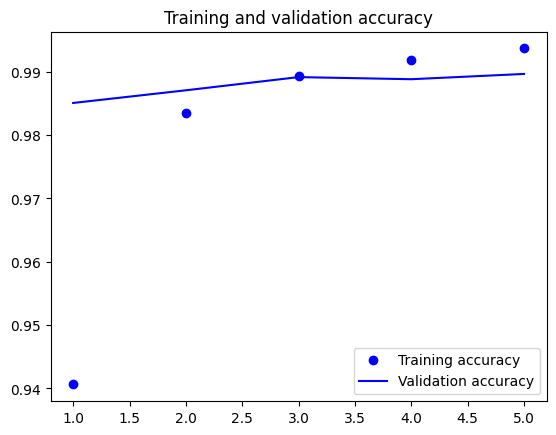

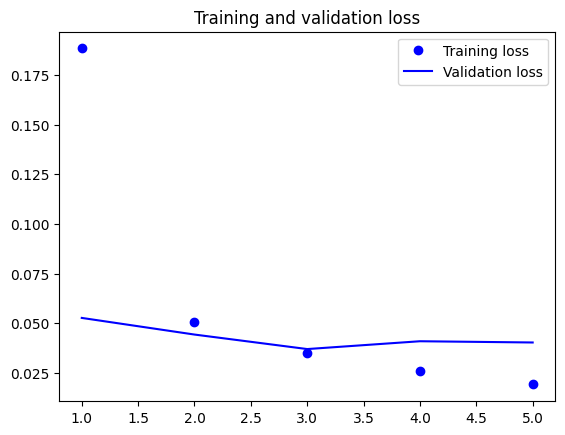

In [56]:
Evaluator.evaluate(cnn_model, test_images, test_labels)
Plotter.plot_history(history)

